# Imports

In [1]:
import os
import sys
from typing import Dict

import numpy as np
from numpy import ndarray

import pandas as pd
from pandas import DataFrame

from matplotlib import pyplot as plt

# Paths

In [2]:
NOTEBOOKS_PATH: str = os.getcwd()
SETTINGS_PATH: str = NOTEBOOKS_PATH.replace("notebooks", "settings")
QSRR_IC_PATH: str = os.path.dirname(NOTEBOOKS_PATH)

OPTIMIZATION_PATH: str = os.path.join(SETTINGS_PATH, "optimization.json")
SINGLE_TRAIN_PATH: str = os.path.join(SETTINGS_PATH, "single_train.json")

In [3]:
for path_ in {NOTEBOOKS_PATH, QSRR_IC_PATH, SETTINGS_PATH}:
    print(f"Path : {path_}")

Path : C:\Users\petar\PycharmProjects\QSRR_IC
Path : C:\Users\petar\PycharmProjects\QSRR_IC\settings
Path : C:\Users\petar\PycharmProjects\QSRR_IC\notebooks


In [4]:
if QSRR_IC_PATH not in sys.path:
    sys.path.append(QSRR_IC_PATH)

In [5]:
# Change the working dir to QSRR IC path
os.chdir(QSRR_IC_PATH)

# QSRR IC module imports

In [6]:
from qsrr_ic.analysis.srd import SumOfRankingDifferences
from qsrr_ic.analysis.srd.domain_models import SrdSettings
from qsrr_ic.config import (
    HyperParameterConfig,
    QsrrIcConfig
)
from qsrr_ic.enums import RegressorType
from qsrr_ic.load import (
    load_dataset,
    QsrrIcData,
    QsrrIcDataset
)
from qsrr_ic.models.iso2grad import Iso2Grad
from qsrr_ic.models.iso2grad.domain_models import Iso2GradData
from qsrr_ic.models.qsrr import QsrrModel
from qsrr_ic.models.qsrr.domain_models import QsrrData
from qsrr_ic.process import ProcessData
from qsrr_ic.runners import (
    QsrrIcModelRunner,    
    QsrrModelRunner
)

# Single Train

This example shows how to train models using the quantitative structure-retention relationships (QSRR) mode & isocratic to gradient (Iso2Grad) model APIs, estimate confidence intervals (CIs) of predictions and metrics using resampling with resplacement, and analyze the models using sum of ranking differences (SRD) / define the models' applicability domain (AD).

## Instantiate `QsrrIcConfig` object using the "single_train.json" example
- `QsrrIcConfig` is an object used to load all configs & settings
- Can be instantiated in three ways:
  * Using the constructor, takes individual config classes, as attributes
  * Using the factory method `QsrrIcConfig::from_dict()` which takes a dictionary of configs/settings
  * Using the method `QsrrIcConfig::from_json(filename="filename.json")` that loads a dictionary of config/settings & instantiates `QsrrIcConfig` using the factory method `QsrrIcConfig::from_dict()`

In [7]:
single_train_config: QsrrIcConfig = QsrrIcConfig.from_json(filename=SINGLE_TRAIN_PATH)

In [8]:
single_train_config.to_dict()

{'dataset': {'molecular_descriptors_for_qsrr_training_path': './datasets/qsrr_ic/2025-01-05-molecular_descriptors_for_qsrr_training.csv',
  'isocratic_retention_path': './datasets/qsrr_ic/2025-01-05-isocratic_retention.csv',
  'molecular_descriptors_for_iso2grad_path': './datasets/qsrr_ic/2025-01-05-molecular_descriptors_for_iso2grad.csv',
  'gradient_void_times_path': './datasets/qsrr_ic/2025-01-05-gradient_void_times.csv',
  'gradient_profiles_path': './datasets/qsrr_ic/2025-01-05-gradient_profiles.csv',
  'gradient_retention_path': './datasets/qsrr_ic/2025-01-05-gradient_retention.csv'},
 'training_type': 'single_train',
 'train_test_split': {'test_ratio': 0.7, 'random_seed': None, 'shuffle': True},
 'hyper_parameters': {'PLS': {'n_components': 4},
  'xGB': {'n_estimators': 497, 'learning_rate': 0.23, 'max_depth': 2},
  'GBR': {'n_estimators': 485, 'learning_rate': 0.23, 'max_depth': 2},
  'RFR': {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 1},
  'ADA': {'n_estimators'

## Load & Prepare Data

In [9]:
# Load the dataset
dataset: QsrrIcDataset = load_dataset(single_train_config.dataset_config)

# Process dataset for training
data: QsrrIcData = ProcessData(dataset).process()

# Prepare & split QSRR data to train/test
qsrr_data: QsrrData = QsrrData(
    y=data.isocratic_retention,
    x=data.molecular_descriptors_for_qsrr_training
)
qsrr_train_data, qsrr_test_data = qsrr_data.split(single_train_config.train_test_split_config)

## Train QSRR models

Configuration class `QsrrIcConfig`, among others, contains an dictionary of `RegressorType`:`HyperParameterConfig` key:value pairs. `HyperParameterConfig` contains an instance of the HyperParameterRegistry that stores hyper-parameters (for single train) or hyper-parameter ranges (for optimization). 

Package *qsrr_ic* in the *QSRR_IC* repository implements singleton ModelRunner classes to run the model training.

Below, we loop over the `RegressorType` & the respective `HyperParameterConfigs`, then instantiate `QsrrModelRunner` that returns instance of `QsrrModel`. `QsrrModel` can also be invoked without using the `QsrrModelRunner` class.

In [10]:
qsrr_models: Dict[RegressorType, QsrrModel] = {}

for regressor_type, hyper_parameter_config in single_train_config.hyper_parameter_config.items():
    
    print(f"Training model: {hyper_parameter_config.to_dict()}")
    
    model_runner = QsrrModelRunner()

    model: QsrrModel = model_runner.run(
        regressor_type=regressor_type,
        qsrr_train_data=qsrr_train_data,
        qsrr_test_data=qsrr_test_data,
        config=hyper_parameter_config
    )
    
    qsrr_models[regressor_type] = model

Training model: {'regressor_type': 'PLS', 'hyper_parameters': {'n_components': 4}}
Training model: {'regressor_type': 'xGB', 'hyper_parameters': {'n_estimators': 497, 'learning_rate': 0.23, 'max_depth': 2}}
Training model: {'regressor_type': 'GBR', 'hyper_parameters': {'n_estimators': 485, 'learning_rate': 0.23, 'max_depth': 2}}
Training model: {'regressor_type': 'RFR', 'hyper_parameters': {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 1}}
Training model: {'regressor_type': 'ADA', 'hyper_parameters': {'n_estimators': 676, 'learning_rate': 0.1284015}}


In [11]:
qsrr_models

{<RegressorType.PLS: 5>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x1271f227640>,
 <RegressorType.xGB: 1>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x12775aa9490>,
 <RegressorType.GBR: 2>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x1271f2639d0>,
 <RegressorType.RFR: 3>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x127222e3c40>,
 <RegressorType.ADA: 4>: <qsrr_ic.models.qsrr.qsrr.QsrrModel at 0x127222e3f40>}

In [12]:
for regressor_type in single_train_config.hyper_parameter_config:
    print(f"Model: {regressor_type.name}")
    print(f"Hyper-parameters: {qsrr_models[regressor_type].hyper_parameters.to_dict()}")
    print(f"Performance: ")
    train_metrics: DataFrame = qsrr_models[regressor_type].train_results.qsrr_metrics.to_df()
    test_metrics: DataFrame = qsrr_models[regressor_type].test_results.qsrr_metrics.to_df()
    metrics: DataFrame = pd.concat((train_metrics, test_metrics), axis=1)
    metrics.columns = ["Training set", "Test set"]
    display(metrics)
    print()

Model: PLS
Hyper-parameters: {'n_components': 4}
Performance: 


,Training set,Test set
R2,0.954163,0.946058
MAE,0.087473,0.100449
MSE,0.012955,0.016069
RMSE,0.113818,0.126765
%MSE,253.195061,NaN
%RMSE,159.121042,NaN



Model: xGB
Hyper-parameters: {'n_estimators': 497, 'learning_rate': 0.23, 'max_depth': 2}
Performance: 


,Training set,Test set
R2,0.999845,0.993598
MAE,0.004689,0.026773
MSE,0.000044,0.001907
RMSE,0.006621,0.043670
%MSE,0.690967,NaN
%RMSE,8.312442,NaN



Model: GBR
Hyper-parameters: {'n_estimators': 485, 'learning_rate': 0.23, 'max_depth': 2}
Performance: 


,Training set,Test set
R2,0.999878,0.994209
MAE,0.004459,0.026347
MSE,0.000034,0.001725
RMSE,0.005869,0.041537
%MSE,0.236330,NaN
%RMSE,4.861379,NaN



Model: RFR
Hyper-parameters: {'n_estimators': 150, 'max_depth': 15, 'min_samples_leaf': 1}
Performance: 


,Training set,Test set
R2,0.998424,0.987742
MAE,0.013577,0.035744
MSE,0.000445,0.003652
RMSE,0.021103,0.060429
%MSE,4.020331,NaN
%RMSE,20.050762,NaN



Model: ADA
Hyper-parameters: {'n_estimators': 676, 'learning_rate': 0.1284015}
Performance: 


,Training set,Test set
R2,0.976620,0.963491
MAE,0.067227,0.082793
MSE,0.006608,0.010876
RMSE,0.081288,0.104288
%MSE,217.562378,NaN
%RMSE,147.499959,NaN


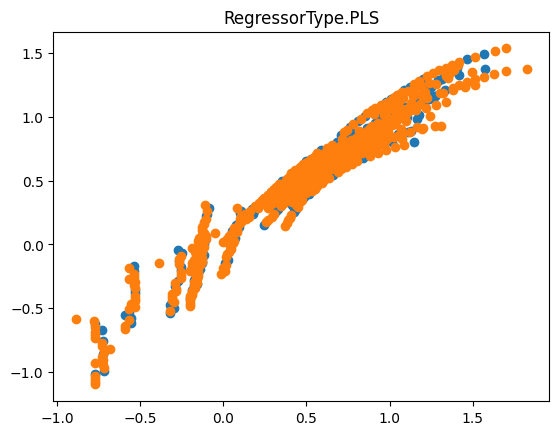

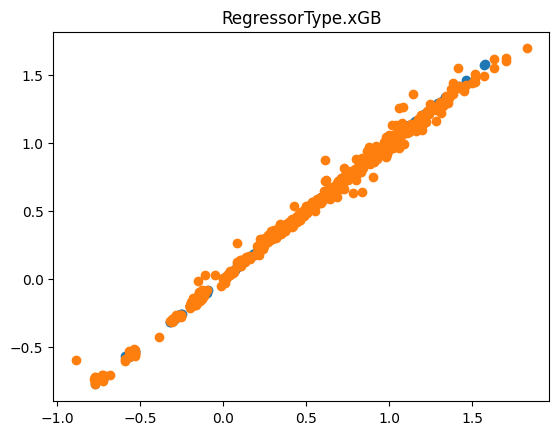

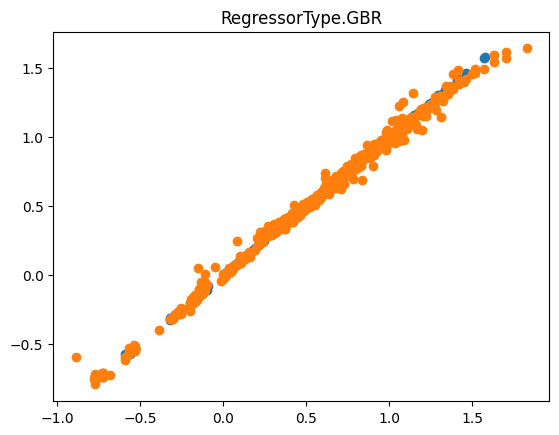

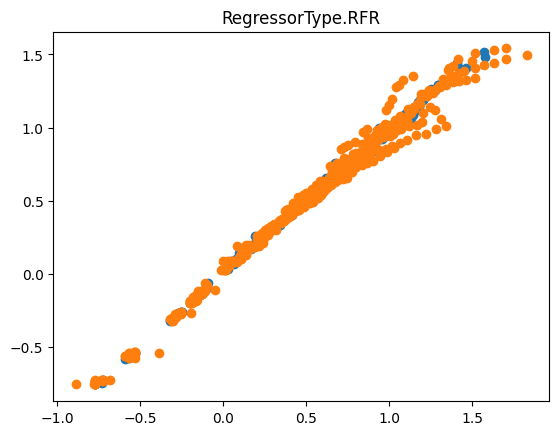

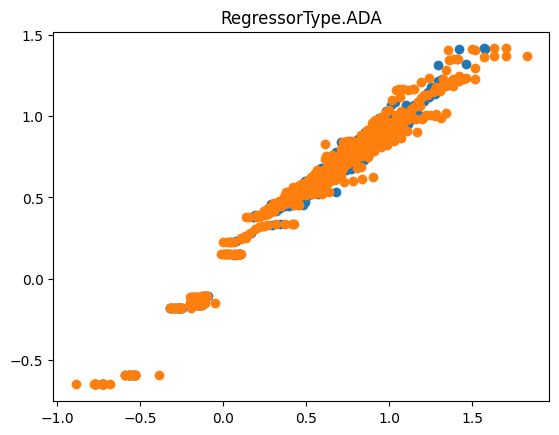

In [13]:
for regressor_type, qsrr_model in qsrr_models.items():

    fig, ax = plt.subplots()

    ax.set_title(regressor_type)a
    
    ax.scatter(
        qsrr_model.qsrr_train_data.y,
        qsrr_model.train_results.qsrr_predictions.y
    )
    ax.scatter(
        qsrr_model.qsrr_test_data.y,
        qsrr_model.test_results.qsrr_predictions.y        
    )

    plt.show()

## Prepare data & settings for iso2grad model

Below, we prepare settings & data for iso2grad modelling.

Settings:
* Integration step
* Number of Python processes to run Iso2Grad in parallel
* Verbosity if parallel calculation

Data needed:
* Molecular descriptors for iso2grad, all descriptors besides the eluent concentration (will be varied during the iso2grad numerical integration process)
* Void times of gradient calculations
* Gradient profiles, only linear profiles supported now
* Gradient retention times, optional data for validation

In [14]:
iso2grad_settings = single_train_config.iso2grad_config.iso2grad_settings
iso2grad_data = Iso2GradData(
    isocratic_model_predictors=data.molecular_descriptors_for_iso2grad,
    gradient_void_times=data.gradient_void_times,
    gradient_retention_profiles=data.gradient_profiles,
    gradient_retention_times=data.gradient_retention
)

In [15]:
data.molecular_descriptors_for_iso2grad.shape

(29, 54)

In [16]:
print(f"Iso2Grad settings: {iso2grad_settings.__dict__}")

Iso2Grad settings: {'integration_step': 0.01, 'n_jobs': 12, 'verbosity': 10}


## Train iso2grad models

Package *qsrr_ic* in the *QSRR_IC* repository implements singleton ModelRunner classes to run the model training.

Below, we loop over the `RegressorType` & the respective `QsrrModels`, then instantiate `QsrrIcModelRunner` that returns instance of `Iso2Grad`. `Iso2Grad` can also be invoked without using the `QsrrIcModelRunner` class.

In [17]:
iso2grad_models: Dict[RegressorType, RegressorType] = {}

for regressor_type, qsrr_model in qsrr_models.items():
    
    print(f"Training iso2grad model using {regressor_type.name} QSRR model")
    
    model_runner = QsrrIcModelRunner()

    model: Iso2Grad = model_runner.run(
        qsrr_model=qsrr_model,
        iso2grad_data=iso2grad_data,
        iso2grad_settings=iso2grad_settings
    )
    
    iso2grad_models[regressor_type] = model

Training iso2grad model using PLS QSRR model


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   14.2s
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:   15.5s remaining:   44.3s
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:   16.3s remaining:   27.7s
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed:   27.2s remaining:   29.3s
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed:   27.3s remaining:   18.8s
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed:   28.3s remaining:   11.9s
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed:   29.0s remaining:    6.5s
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed:   34.9s remaining:    2.7s
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed:   36.2s finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using xGB QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   28.4s
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:   35.7s remaining:  1.7min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:   41.2s remaining:  1.2min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed:  1.0min remaining:  1.1min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed:  1.1min remaining:   43.4s
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed:  1.1min remaining:   27.7s
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed:  1.2min remaining:   16.1s
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed:  1.3min remaining:    6.2s
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using GBR QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:   32.0s
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:   38.7s remaining:  1.8min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:   40.6s remaining:  1.2min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed:  1.1min remaining:   45.8s
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed:  1.2min remaining:   29.2s
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed:  1.2min remaining:   16.1s
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed:  1.3min remaining:    6.4s
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed:  1.5min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using RFR QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:  4.8min
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed:  6.1min remaining: 17.5min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed:  6.5min remaining: 11.1min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed:  9.7min remaining: 10.5min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed: 10.4min remaining:  7.2min
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed: 10.7min remaining:  4.5min
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed: 11.4min remaining:  2.6min
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed: 12.7min remaining:  1.0min
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed: 13.7min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


Training iso2grad model using ADA QSRR model


[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed: 38.7min
[Parallel(n_jobs=12)]: Done   7 out of  27 | elapsed: 48.3min remaining: 138.1min
[Parallel(n_jobs=12)]: Done  10 out of  27 | elapsed: 49.7min remaining: 84.5min
[Parallel(n_jobs=12)]: Done  13 out of  27 | elapsed: 79.4min remaining: 85.5min
[Parallel(n_jobs=12)]: Done  16 out of  27 | elapsed: 84.0min remaining: 57.8min
[Parallel(n_jobs=12)]: Done  19 out of  27 | elapsed: 86.3min remaining: 36.4min
[Parallel(n_jobs=12)]: Done  22 out of  27 | elapsed: 91.1min remaining: 20.7min
[Parallel(n_jobs=12)]: Done  25 out of  27 | elapsed: 105.4min remaining:  8.4min
[Parallel(n_jobs=12)]: Done  27 out of  27 | elapsed: 112.7min finished


In [20]:
iso2grad_models

{<RegressorType.PLS: 5>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x1273589d3a0>,
 <RegressorType.xGB: 1>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x127358f8e20>,
 <RegressorType.GBR: 2>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x127358e2520>,
 <RegressorType.RFR: 3>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x127359c9490>,
 <RegressorType.ADA: 4>: <qsrr_ic.models.iso2grad.iso2grad.Iso2Grad at 0x127359ce940>}

In [21]:
for regressor_type in single_train_config.hyper_parameter_config:
    print(f"Model: {regressor_type.name}")
    print(f"Performance: ")
    iso2grad_metrics: DataFrame = iso2grad_models[regressor_type].results.metrics.to_df()
    display(iso2grad_metrics)
    print()

Model: PLS
Performance: 


,0
R2,-0.719383
MAE,7.842700
MSE,107.893737
RMSE,10.387191
%MSE,1092.001227
%RMSE,330.454419



Model: xGB
Performance: 


,0
R2,-1.051767
MAE,8.645665
MSE,128.751354
RMSE,11.346865
%MSE,1807.651840
%RMSE,425.164890



Model: GBR
Performance: 


,0
R2,-0.942185
MAE,8.397223
MSE,121.874878
RMSE,11.039696
%MSE,1541.638507
%RMSE,392.637047



Model: RFR
Performance: 


,0
R2,-0.827118
MAE,8.216094
MSE,114.654247
RMSE,10.707672
%MSE,1402.228110
%RMSE,374.463364



Model: ADA
Performance: 


,0
R2,-0.657051
MAE,7.761540
MSE,103.982307
RMSE,10.197172
%MSE,1028.466599
%RMSE,320.697147


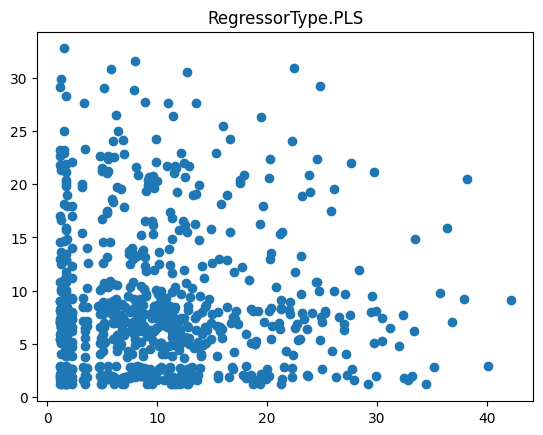

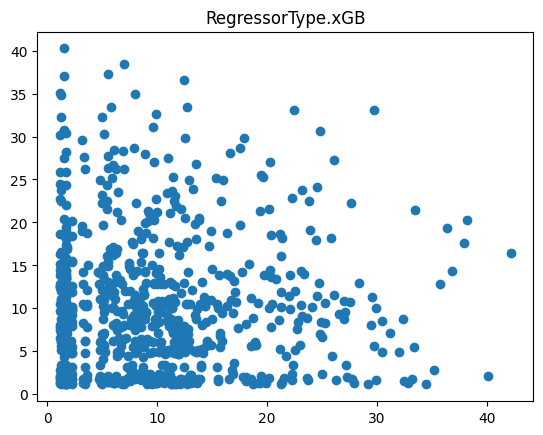

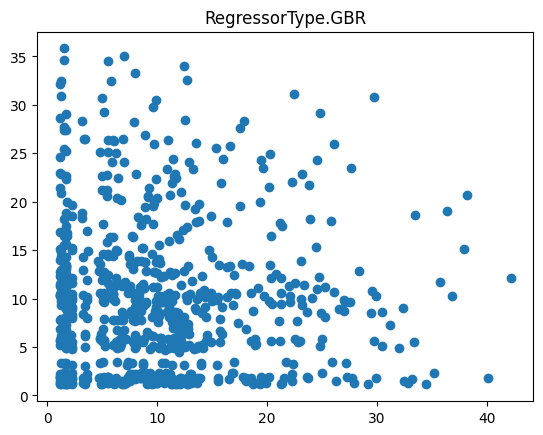

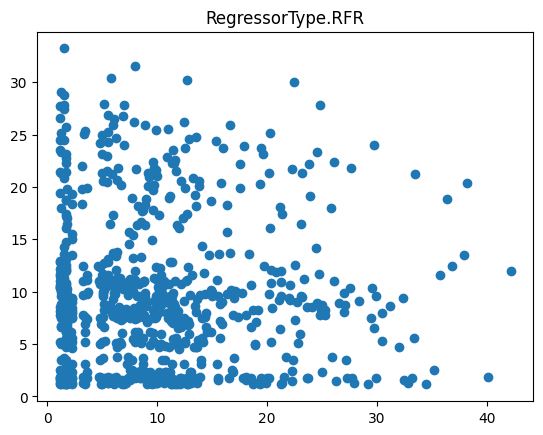

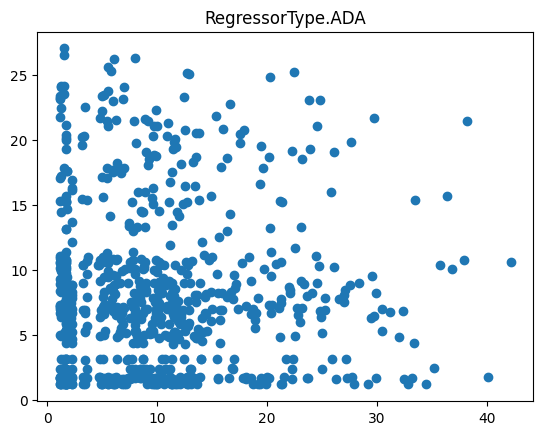

In [214]:
for regressor_type, iso2grad_model in iso2grad_models.items():

    fig, ax = plt.subplots()

    ax.set_title(regressor_type)
    
    ax.scatter(
        iso2grad_models[regressor_type].results.metrics.qsrr_data.y,
        iso2grad_models[regressor_type].results.metrics.qsrr_predictions.y
    )

    plt.show()

In [218]:
iso2grad_models[regressor_type].results.gradient_retention_times.shape

(783,)

## SRD Analysis

### SRD for QSRR models

In [29]:
# Calculate SRD for QSRR models
qsrr_srds: Dict[RegressorType, SumOfRankingDifferences] = {}

for regressor_type, qsrr_model in qsrr_models.items():
    qsrr_srds[regressor_type] = SumOfRankingDifferences(
        # Inputs = predictions
        inputs=np.vstack((qsrr_model.train_results.qsrr_predictions.y, qsrr_model.test_results.qsrr_predictions.y)).reshape(-1, 1),
        # Golden reference = exp retention data
        golden_reference=np.vstack((qsrr_model.qsrr_train_data.y, qsrr_model.qsrr_test_data.y)).reshape(-1, 1)
    )

In [211]:
# Can get from any, as they are random
normalized_random_srds = qsrr_srds[RegressorType.PLS].normalized_random_srds
srds: Dict[RegressorType, ndarray] = {}
normalized_srds: Dict[RegressorType, ndarray] = {}

for regressor_type, qsrr_srd in qsrr_srds.items():
    srds[regressor_type] = qsrr_srd.srds
    normalized_srds[regressor_type] = qsrr_srd.normalized_srds

srds_df = pd.DataFrame.from_dict(srds, orient="index")
normalized_srds_df = pd.DataFrame.from_dict(normalized_srds, orient="index")

In [213]:
display(srds_df)
display(normalized_srds_df)

,0
RegressorType.PLS,24072.0
RegressorType.xGB,6022.0
RegressorType.GBR,5584.0
RegressorType.RFR,7824.0
RegressorType.ADA,16112.0


,0
RegressorType.PLS,9.159399
RegressorType.xGB,2.291372
RegressorType.GBR,2.124713
RegressorType.RFR,2.977033
RegressorType.ADA,6.130618


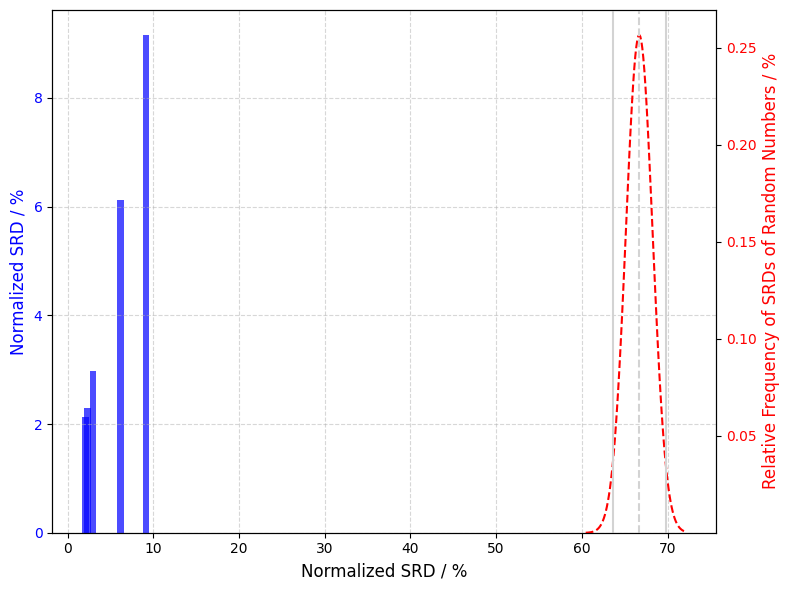

In [209]:
# Fit a normal distribution to the data
mu, std = norm.fit(normalized_random_srds_)

# Create a range of x values (for plotting the normal distribution)
x = np.linspace(normalized_random_srds_.min(), normalized_random_srds_.max(), 100)

# Get the probability density function for the normal distribution
p = norm.pdf(x, mu, std)

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the bar chart on the left y-axis
ax1.bar(normalized_srds_df.values.ravel(), normalized_srds_df.values.ravel(), color='blue', alpha=0.7, label="Normalized SRD / %")
ax1.set_xlabel("Normalized SRD / %", fontsize=12)
ax1.set_ylabel("Normalized SRD / %", fontsize=12, color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Create the second y-axis for the fitted normal distribution
ax2 = ax1.twinx()
ax2.plot(x, p, color='red', linestyle='--')
ax2.set_ylabel("Relative Frequency of SRDs of Random Numbers / %", fontsize=12, color="red")
ax2.tick_params(axis='y', labelcolor="red")

p_min = p.min()
p_max = p.max() + 0.05 * p.max()

ax2.vlines(mu - 2 * std, p_min, p_max, color="lightgrey", linestyle="-")
ax2.vlines(mu, p_min, p_max, color="lightgrey", linestyle="--")
ax2.vlines(mu + 2 * std, p_min, p_max, color="lightgrey", linestyle="-")

ax2.set_ylim(p_min, p_max)

ax1.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()

# Show the plot
plt.show()

### SRD for iso2grad models

In [210]:
# Calculate SRD for iso2grad models
iso2grad_srds: Dict[RegressorType, SumOfRankingDifferences] = {}

for regressor_type, iso2grad_model in iso2grad_models.items():
    iso2grad_srds[regressor_type] = SumOfRankingDifferences(
        # Inputs = gradient time predictions
        inputs=iso2grad_model.results.gradient_retention_times,
        # Golden reference = exp gradient retention data
        golden_reference=iso2grad_data.gradient_retention_times
    )